In [2]:
from __future__ import print_function

import numpy as np
import yt
import unyt
from yt.units import *
from yt import YTArray
import argparse
import os
import glob
import sys
from astropy.table import Table
from astropy.io import ascii
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from scipy import interpolate
from scipy.signal import correlate2d
#from photutils import detect_threshold, detect_sources, source_properties, EllipticalAperture
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.stats import binned_statistic
from scipy.optimize import minimize
import trident
import ast
#import emcee
import numpy.random as rn
from multiprocessing import Pool
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from yt.units import kpc, cm
import cmasher as cmr
from itertools import combinations
import builtins
from scipy.optimize import curve_fit
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u


# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_refine_box import get_refine_box
from foggie.utils.get_halo_center import get_halo_center
from foggie.utils.get_proper_box_size import get_proper_box_size
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *
from foggie.utils.analysis_utils import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd
import matplotlib as mpl
import h5py
import matplotlib.cm as mtcm
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import os

from mpl_toolkits.mplot3d.art3d import Line3DCollection

from foggie.clumps.clump_finder.utils_diskproject import load_disk 
from collections import defaultdict
import pandas as pd
import math
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


from foggie.clumps.clump_finder.utils_clump_finder import *
from foggie.clumps.clump_finder.clump_finder_argparser import *
from foggie.clumps.clump_finder.fill_topology import *
from foggie.clumps.clump_finder.clump_load import *
from foggie.clumps.clump_finder.clump_finder import clump_finder



In [3]:
def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_data/"
    code_base_path = "/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref9")

    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir

# specify halo and snapshot
run = 'nref11c_nref9f'

ions = ['HI','OVI', 'CIV', 'SiIV', 'CIII', 'SiIII', 'MgII', 'SiII']
orientations = ['face','edge']
regions = ['all','cgm'] 
cmap = mtcm.get_cmap('Set1', len(ions))  

box_name = '100'
output = 'RD0032'
snap = output
resolutions = [0.27,1,3,6]
if snap == 'RD0042':
    halos = ['2392','4123','5016','5036','8508']
    z = '0.0'
elif snap == 'RD0040':
    halos = ['2878','2392','4123','5016','5036','8508']
    z = '0.1'
elif snap == 'RD0032':
    halos = ['2878','2392','4123','5016','5036','8508']
    z = '0.5'

unit_system = 'photons'

log_vals = [100,200,300,400,500,1000,2000,3000,4000]#1,10,25,50,75,

flux_thresholds = {
    'HI': list(log_vals),
    'CII': list(log_vals),
    'CIII': list(log_vals),
    'CIV': list(log_vals),
    'OVI': list(log_vals),
    'MgII': list(log_vals),
    'SiII': list(log_vals),
    'SiIII': list(log_vals),
    'SiIV': list(log_vals)}

    

/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_89491/229755489.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mtcm.get_cmap('Set1', len(ions))


Table 3

In [4]:
# 1. Unit coversion: converting spatial resolution from arcsec to kpc

def spatial_resolution(theta_arcsec, z):
    """
    Convert angular resolution (arcsec) at redshift z
    into physical scale (kpc).
    
    Parameters
    ----------
    theta_arcsec : float
        Angular resolution in arcseconds.
    z : float
        Target redshift.
    
    Returns
    -------
    float
        Physical resolution in kpc.
    """
    # Angular diameter distance in kpc
    DA = cosmo.angular_diameter_distance(z).to(u.kpc).value
    
    # Convert arcsec to radians
    theta_rad = theta_arcsec * (np.pi / 648000.0)
    
    # Physical size in kpc
    return theta_rad * DA




In [5]:
print(np.round(spatial_resolution(0.03, 2), 2),"kpc")

0.26 kpc


In [6]:
# convert velocity to R
def velocity_to_R(delta_v_kms):
    """
    Convert spectral resolution from velocity units (km/s) 
    to resolving power R.
    
    Parameters
    ----------
    delta_v_kms : float or list of floats
        Spectral resolution in km/s.
        
    Returns
    -------
    float or list of floats
        Resolving power R.
    """
    c = 299792.458  # speed of light in km/s
    if isinstance(delta_v_kms, (list, tuple)):
        return [c / dv for dv in delta_v_kms]
    else:
        return c / delta_v_kms

In [7]:
delta_v_kms = 400
velocity_to_R(delta_v_kms)

749.481145

In [8]:
# converting surface brightness from erg/s/cm^2/arcsec^2 to photons/s/cm^2/sr following equation: 

def sb_to_photons(f_lambda, wavelength_A):
    """
    Convert surface brightness from erg/s/cm^2/arcsec^2 
    to photons/s/cm^2/sr at a given wavelength.
    
    Parameters
    ----------
    f_lambda : float
        Surface brightness in erg/s/cm^2/arcsec^2
    wavelength_A : float
        Wavelength in Angstroms (Å)
        
    Returns
    -------
    float
        Photon surface brightness in photons/s/cm^2/sr
    """
    # constants
    h = 6.62607015e-27  # erg*s
    c = 2.99792458e10   # cm/s
    
    # energy per photon
    wavelength_cm = wavelength_A * 1e-8
    E_photon = h * c / wavelength_cm
    
    # convert arcsec^2 -> sr
    arcsec2_to_sr = (np.pi / (180.0 * 3600.0))**2 # = 1 / 4.25e10
    
    # convert SB to erg/s/cm^2/sr
    sb_erg_sr = f_lambda / arcsec2_to_sr
    
    # photons
    f_LU = sb_erg_sr / E_photon
    return f_LU

In [9]:
# Example: OVI Hayes et al 2016 detection 1032 Å, SB = 1e-17 erg/s/cm^2/arcsec^2
sb_limit = 2e-19
wavelength = 6563  # Å
print(sb_to_photons(sb_limit, wavelength), "photons cm^-2 s^-1 sr^-1")

2811.29185221697 photons cm^-2 s^-1 sr^-1


In [10]:
# Converting surface brightness limits between exposure times

def sb_scale(sb_ref, t_ref_hr, t_new_hr):
    """
    Scale a surface-brightness (SB) limit between exposure times assuming background-limited regime:
        SB = 1/sqrt(t)
        SB_new/SB_ref = sqrt(t_ref / t_new)
        SB_new = SB_ref * sqrt(t_ref / t_new)

    Parameters
    ----------
    sb_ref : float
        Reference SB limit in erg/s/cm^2/arcsec^2.
    t_ref_hr : float
        Reference exposure time in hours.
    t_new_hr : float or array-like
        New exposure time(s) in hours.

    Returns
    -------
    float or np.ndarray
        Scaled SB limit(s) in erg/s/cm^2/arcsec^2.
    """
    t_new_hr = np.asarray(t_new_hr, dtype=float)
    return sb_ref * np.sqrt(t_ref_hr / t_new_hr)


def convert_sb_erg_to_ph(sb_ref_erg_arcsec2, t_ref_hr, t_list_hr, wavelength_A):
    """
    scale an SB limit from a reference exposure time to a list of new exposure times
    and convert each to photons/s/cm^2/sr at the given wavelength.

    Returns a dict with both erg and photon units.
    """
    t_list_hr = np.atleast_1d(t_list_hr).astype(float)
    sb_scaled_erg = sb_scale(sb_ref_erg_arcsec2, t_ref_hr, t_list_hr)
    sb_scaled_phot = sb_to_photons(sb_scaled_erg, wavelength_A)
    return {
        "exposures_hr": t_list_hr,
        "sb_erg_arcsec2": sb_scaled_erg,
        "sb_photons_sr": sb_scaled_phot,
    }

def convert_sb_ph(sb_ref_erg_arcsec2, t_ref_hr, t_list_hr):
    """
    scale an SB limit from a reference exposure time to a list of new exposure times

    Returns a dict in photon units.
    """
    t_list_hr = np.atleast_1d(t_list_hr).astype(float)
    sb_scaled_ph = sb_scale(sb_ref_erg_arcsec2, t_ref_hr, t_list_hr)
    
    return {
        "exposures_hr": t_list_hr,
        "sb_photons_sr": sb_scaled_ph,
    }#




In [11]:
# ---- Example: MAGPIE, O VI 1032 Å ----
# Given: SB_ref = 3e-19 erg/s/cm^2/arcsec^2 at t_ref = 41.7 hr
example = convert_sb_erg_to_ph(
    sb_ref_erg_arcsec2=1e-17,
    t_ref_hr=2,
    t_list_hr=[10, 100],
    wavelength_A=3727
)

for t, sb_erg, sb_ph in zip(example["exposures_hr"], example["sb_erg_arcsec2"], example["sb_photons_sr"]):
    print(f"Exposure = {t:6.1f} hr | SB = {sb_erg:.3e} erg/s/cm^2/arcsec^2 | "
          f"{sb_ph:7.1f} photons/s/cm^2/sr (OVI 1032 Å)")

Exposure =   10.0 hr | SB = 4.472e-18 erg/s/cm^2/arcsec^2 | 35698.3 photons/s/cm^2/sr (OVI 1032 Å)
Exposure =  100.0 hr | SB = 1.414e-18 erg/s/cm^2/arcsec^2 | 11288.8 photons/s/cm^2/sr (OVI 1032 Å)


In [12]:
# ---- Example: MAGPIE, O VI 1032 Å ----
# Given: SB_ref = 625 photons at t_ref = 41.7 hr

example = convert_sb_ph(
    sb_ref_erg_arcsec2=160,
    t_ref_hr=10,
    t_list_hr=[10, 100]
)

for t, sb_ph in zip(example["exposures_hr"], example["sb_photons_sr"]):
    print(f"Exposure = {t:6.1f} hr | "
          f"{sb_ph:7.1f} photons/s/cm^2/sr ( Å)")
    

Exposure =   10.0 hr |   160.0 photons/s/cm^2/sr ( Å)
Exposure =  100.0 hr |    50.6 photons/s/cm^2/sr ( Å)


Figure 15

/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_89491/2221468534.py:277: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.0)


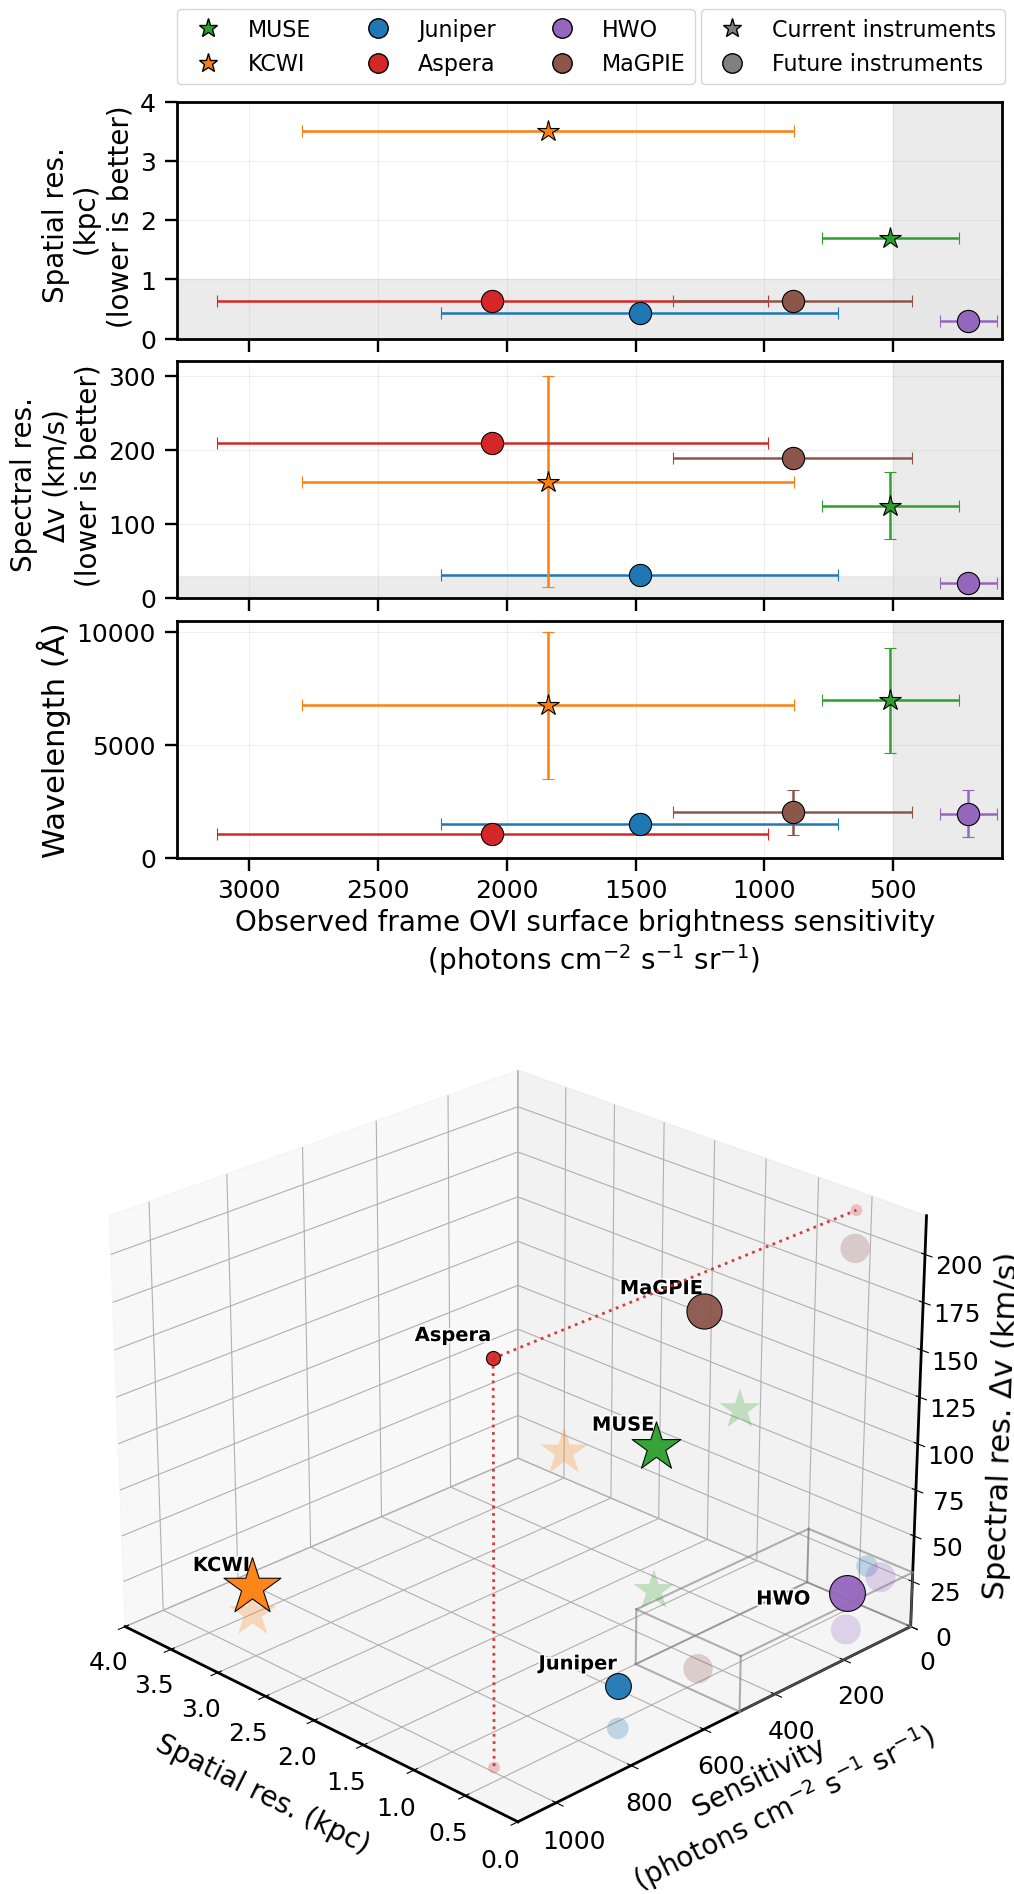

Saved: /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/Conclusion/instruments_markers_errorbars.png


In [13]:


def add_corner_wireframe(ax, x1=1.0, y1=500.0, z1=50.0, color='0.35', lw=1.5, dash=False, alpha=0.6, **_):
    """3D wireframe using Line3D objects (plays nicer with depth sorting)."""
    ls = (0, (4, 3)) if dash else 'solid'
    edges = []

    # edges parallel to x
    edges += [((0,0,0),(x1,0,0)), ((0,y1,0),(x1,y1,0)),
              ((0,0,z1),(x1,0,z1)), ((0,y1,z1),(x1,y1,z1))]
    # edges parallel to y
    edges += [((0,0,0),(0,y1,0)), ((x1,0,0),(x1,y1,0)),
              ((0,0,z1),(0,y1,z1)), ((x1,0,z1),(x1,y1,z1))]
    # edges parallel to z
    edges += [((0,0,0),(0,0,z1)), ((x1,0,0),(x1,0,z1)),
              ((0,y1,0),(0,y1,z1)), ((x1,y1,0),(x1,y1,z1))]

    for (x0,y0,z0),(x1_,y1_,z1_) in edges:
        line, = ax.plot([x0,x1_],[y0,y1_],[z0,z1_],
                        color=color, linewidth=lw, alpha=alpha, linestyle=ls)
        # If available, push lines "to the back" in the 3D sorter
        if hasattr(line, "set_sort_zpos"):
            try:
                line.set_sort_zpos(-1e6)
            except Exception:
                pass




# -----------------------
# Data (from your updated table)
# -----------------------
rows = [
    
    ("Juniper", 0.43, (713, 2256),  (23, 40),     (1025, 1929)),
    ("KCWI",    3.5,  (884, 2795),  (15, 300),    (3500, 10000)),
    ("MUSE",    1.7,  (246, 778),   (80, 170),    (4650, 9300)),
    ("Aspera",  0.64, (987, 3123),  (210, 210),   (1030, 1040)),# changed the spectral re for clarity
    ("HWO",     0.3, (100, 320),   (20, 20),     (900, 3000)),
    ("MaGPIE",  0.64, (428, 1354),  (190, 190),   (1000, 3000)),# changed the spectral re for clarity
    
]
#("HWO",     0.3, (100, 320),   (20, 20),     (1000, 10000)),# changed the spatial re for clarity
#("HARMONI",  0.26, (50, 155),  (17, 90),   (4600, 24600))# changed the spectral re for clarity
#("MaGPIE",  6.37, (428, 1354),  (190, 190),   (1000, 3000)),# changed the spectral re for clarity

df = pd.DataFrame({
    "Instrument":      [r[0] for r in rows],
    "Spatial_kpc":     [r[1] for r in rows],
    "Sensitivity_min": [r[2][0] for r in rows],   # OVI (100 hr)
    "Sensitivity_max": [r[2][1] for r in rows],   # OVI (10 hr)
    "SpecRes_min":     [r[3][0] for r in rows],   # Δv (km/s)
    "SpecRes_max":     [r[3][1] for r in rows],
    "Wav_min":         [r[4][0] for r in rows],   # Å
    "Wav_max":         [r[4][1] for r in rows],
})

# label_offsets = {
#     # (dx in kpc, dy in sensitivity units, dz in km/s, ha, va)
#     "HWO":      ( 0.2,  110, 0, 'left',  'bottom'),"HARMONI":  ( -0.12,  -45,  12, 'right', 'bottom'),
#     # tweak others here if needed
# }
label_offsets = {
    # (dx in kpc, dy in sensitivity units, dz in km/s, ha, va)
    "HWO":      ( 0.3,  175, 0, 'left',  'bottom')
    # tweak others here if needed
}

def mid_min_max(lo, hi):
    lo, hi = float(lo), float(hi)
    return 0.5*(lo+hi), lo, hi

def sens_mid_err(row):
    xm, lo, hi = mid_min_max(row["Sensitivity_min"], row["Sensitivity_max"])
    return xm, np.array([[xm - lo], [hi - xm]])

def spec_mid_err(row):
    ym, lo, hi = mid_min_max(row["SpecRes_min"], row["SpecRes_max"])
    return ym, np.array([[ym - lo], [hi - ym]])

def wav_mid_err(row):
    ym, lo, hi = mid_min_max(row["Wav_min"], row["Wav_max"])
    return ym, np.array([[ym - lo], [hi - ym]])

# -----------------------
# Styling
# -----------------------
current = {"MUSE", "KCWI"}  # current missions
palette = plt.cm.tab10(np.linspace(0, 1, max(10, len(df))))
instr2color = {inst: palette[i % len(palette)] for i, inst in enumerate(df["Instrument"])}

def shape_for(inst):
    return '*' if inst in current else 'o'

# -----------------------
# Figure (3 stacked 2D + 1 wide 3D)
# -----------------------
plt.close('all')
fig = plt.figure(figsize=(10, 18), constrained_layout=True)

gs = fig.add_gridspec(2, 1, height_ratios=[2, 2])

gs_top = gs[0].subgridspec(3, 1, hspace=0.0)

axA = fig.add_subplot(gs_top[0, 0])             # Spatial vs Sensitivity
axB = fig.add_subplot(gs_top[1, 0], sharex=axA) # Spectral vs Sensitivity
axC = fig.add_subplot(gs_top[2, 0], sharex=axA) # Wavelength vs Sensitivity
axD = fig.add_subplot(gs[1], projection='3d')   # 3D

for ax in (axA, axB):
    ax.tick_params(axis='x', labelbottom=False)

    

# -----------------------
# X limits (sensitivity) and shading thresholds
# -----------------------
XMIN = float(builtins.min(df["Sensitivity_min"].min(), df["Sensitivity_max"].min()) * 0.8)
XMAX = float(builtins.max(df["Sensitivity_min"].max(), df["Sensitivity_max"].max()) * 1.05)
SHADE = dict(color='0.9', alpha=0.8, zorder=0) 

# --- Panel A
axA.set_ylabel("Spatial res. \n (kpc) \n (lower is better)", fontsize=20)
axA.set_xlim(XMIN, XMAX); axA.invert_xaxis()
axA.set_ylim(0, max(4.0, float(df["Spatial_kpc"].max()) + 0.5))#; axA.invert_yaxis()
axA.grid(True, alpha=0.2)
axA.axvspan(XMIN, 500, **SHADE)  # sensitivity < 500
axA.axhspan(0, 1, **SHADE)       # spatial < 1 kpc
for _, r in df.iterrows():
    inst, col, m = r["Instrument"], instr2color[r["Instrument"]], shape_for(r["Instrument"])
    xmid, xerr = sens_mid_err(r)
    ymid = float(r["Spatial_kpc"])
    axA.errorbar(xmid, ymid, xerr=xerr, yerr=None, fmt=m, ms=16, color=col, ecolor=col,
                 elinewidth=1.8, capsize=4, mec='k', mew=0.8)

# --- Panel B
axB.set_ylabel("Spectral res. \n Δv (km/s)\n (lower is better)", fontsize=20)
axB.set_xlim(XMIN, XMAX); axB.invert_xaxis()
axB.set_ylim(0, max(320.0, float(df["SpecRes_max"].max()) * 1.05))#; axB.invert_yaxis()
axB.grid(True, alpha=0.2)
axB.axvspan(XMIN, 500, **SHADE)  # sensitivity < 500
axB.axhspan(0, 30, **SHADE)      # Δv ≤ 50
for _, r in df.iterrows():
    inst, col, m = r["Instrument"], instr2color[r["Instrument"]], shape_for(r["Instrument"])
    xmid, xerr = sens_mid_err(r)
    ymid, yerr = spec_mid_err(r)
    axB.errorbar(xmid, ymid, xerr=xerr, yerr=yerr, fmt=m, ms=16, color=col, ecolor=col,
                 elinewidth=1.8, capsize=4, mec='k', mew=0.8)

# --- Panel C
axC.set_xlabel("Observed frame OVI surface brightness sensitivity \n (photons cm$^{-2}$ s$^{-1}$ sr$^{-1}$)", fontsize=20)
axC.set_ylabel("Wavelength (Å)", fontsize=22)
axC.set_xlim(XMIN, XMAX); axC.invert_xaxis()
axC.set_ylim(0, float(df["Wav_max"].max()) * 1.05)
axC.grid(True, alpha=0.2)
axC.axvspan(XMIN, 500, **SHADE)  # sensitivity < 500
for _, r in df.iterrows():
    inst, col, m = r["Instrument"], instr2color[r["Instrument"]], shape_for(r["Instrument"])
    xmid, xerr = sens_mid_err(r)
    ymid, yerr = wav_mid_err(r)
    axC.errorbar(xmid, ymid, xerr=xerr, yerr=yerr, fmt=m, ms=16, color=col, ecolor=col,
                 elinewidth=1.8, capsize=4, mec='k', mew=0.8)
    
# === Make all 2D plot borders thicker ===
for ax in [axA, axB, axC]:
    for spine in ax.spines.values():
        spine.set_linewidth(2)     
        spine.set_color('black')  

# -----------------------
# Panel D: 3D scatter (no error bars) + gray box + wall shadows
# -----------------------
# --- Highlight "best" corner cleanly (wireframe only)
add_corner_wireframe(axD, x1=1.0, y1=500.0, z1=30.0, color='gray', lw=1.5, dash=False, zorder=-5, alpha=0.6)

axD.set_xlabel("Spatial res. (kpc)", fontsize=20, labelpad=20)
axD.set_ylabel("Sensitivity \n (photons cm$^{-2}$ s$^{-1}$ sr$^{-1}$)", fontsize=20, labelpad=20)
axD.set_zlabel("Spectral res. Δv (km/s)", fontsize=22, labelpad=14)

# === Make 3D axes borders (cube edges) thicker and darker ===
axD.xaxis.line.set_linewidth(2)
axD.yaxis.line.set_linewidth(2)
axD.zaxis.line.set_linewidth(2)

xmax3d = max(4.0, float(df["Spatial_kpc"].max()) * 1.05)
ymax3d = XMAX
zmax3d = max(320.0, float(df["SpecRes_max"].max()) * 1.05)
axD.set_xlim(0, xmax3d)
axD.set_ylim(0, 1100)
axD.set_zlim(0, 220)
axD.view_init(elev=25, azim=135)
try:
    axD.set_box_aspect((1,1,0.8))
except Exception:
    pass




# --- Scatter points + wall shadows
for _, r in df.iterrows():
    inst = r["Instrument"]; col = instr2color[inst]; m = shape_for(inst)
    x = float(r["Spatial_kpc"])                # spatial (single value)
    y = float(r["Sensitivity_min"])            # best sensitivity (100 hr)
    z = float(r["SpecRes_min"])                # best Δv
    wav_span = 3 * float(r["Wav_max"] - r["Wav_min"])
    size = 100 + 0.09 * wav_span

    # Main point
    axD.scatter(x, y, z, s=size, c=[col], marker=m, edgecolor='k', linewidths=0.8, alpha=0.95)
    #axD.text(x, y, z + 16, inst, fontsize=10, ha='center', va='bottom', weight='bold')

    # --- label with per-instrument offset + leader line
    dx, dy, dz, ha, va = label_offsets.get(inst, (0.0, 5.0, 7.0, 'right', 'bottom'))
    xt, yt, zt = x + dx, y + dy, z + dz

    # text with a light stroke for readability
    import matplotlib.patheffects as pe
    axD.text(
        xt, yt, zt, inst, fontsize=14, ha=ha, va=va, weight='bold',
        path_effects=[pe.withStroke(linewidth=2.5, foreground='white', alpha=0.9)]
    )

    # Shadows (mirrors):
    sh_alpha = 0.25
    sh_ec = 'none'
    # 1) Spatial × Sensitivity plane (xy): z=0
    axD.scatter(x, y, 0, s=size*0.7, c=[col], marker=m, alpha=sh_alpha, edgecolor=sh_ec)
    # 2) Sensitivity × Spectral plane (yz): x=0
    axD.scatter(x, 0, z, s=size*0.7, c=[col], marker=m, alpha=sh_alpha, edgecolor=sh_ec)

    if inst == "Aspera":
        # to z=0 plane (xy)
        axD.plot([x, x], [y, y], [z, 0],
                linestyle=':', color=col, lw=2, alpha=0.9, zorder=10)
        # to x=0 plane (yz)
        axD.plot([x, x], [y, 0], [z, z],
                linestyle=':', color=col, lw=2, alpha=0.9, zorder=10)
        
#---------------- axis tick sizes
# 2D axes
for ax in (axA, axB, axC):
    ax.tick_params(axis='both', which='both',
                   labelsize=18, length=9, width=1.7, pad=6)

# 3D axis (do x, y, and z explicitly)
axD.tick_params(axis='x', which='both',
                labelsize=18, length=9, width=2, pad=6)
axD.tick_params(axis='y', which='both',
                labelsize=18, length=9, width=2, pad=6)
axD.tick_params(axis='z', which='both',
                labelsize=18, length=9, width=2, pad=6)

# -----------------------
# Legends
# -----------------------
# Instruments legend: first the two current missions (stars), then the rest (circles)
order = ["MUSE", "KCWI"] + [inst for inst in df["Instrument"] if inst not in {"MUSE", "KCWI"}]
instr_handles = []
for inst in order:
    marker = '*' if inst in current else 'o'
    instr_handles.append(Line2D([0],[0], marker=marker, color='w', label=inst,
                                markerfacecolor=instr2color[inst], markeredgecolor='k', markersize=14))

# Status legend (shape-only explanation)
status_handles = [
    Line2D([0],[0], marker='*', color='w', label='Current instruments',
           markerfacecolor='gray', markeredgecolor='k', markersize=14),
    Line2D([0],[0], marker='o', color='w', label='Future instruments',
           markerfacecolor='gray', markeredgecolor='k', markersize=14),
]

# Place legends
fig.legend(handles=instr_handles, loc='upper center',
           bbox_to_anchor=(0.43, 1.05), ncol=3, frameon=True, fontsize=16)
fig.legend(handles=status_handles, loc='upper right',
           bbox_to_anchor=(1.01, 1.05), frameon=True, fontsize=16)
plt.subplots_adjust(hspace=0.0)

# -----------------------
# Save
# -----------------------
output_path = '/Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/Conclusion/'
os.makedirs(output_path, exist_ok=True)
out_file = os.path.join(output_path, 'instruments_markers_errorbars.png')
plt.savefig(out_file, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"Saved: {out_file}")
